# k-Means Algorithm on pyspark

This assignment focuses on modifying the traditional k-Means clustering algorithm so that it can be used in a Map Reduce framework.

## About the data

The data in total consists of three files

- 'data.txt': Contains 4601 rows and 58 columns. Each row is a document represented as a 58 dimensional vector of features. Each component in
the vector represents the importance of a word in the document.
- c1.txt contains k initial cluster centroids. These centroids were chosen by selecting k = 10 random points from the input data.
- c2.txt contains initial cluster centroids which are as far apart as possible. (You can do this by choosing the 1st centroid c1 randomly, and then finding the point c2 that is farthest from c1, then selecting c3 which is farthest from c1 and c2, and so on).
- vocab.txt is the vocabulary document that contains the words, this file is only for your reference and you do not need it to do the experiment.

In [11]:
import os

current_file_dir = os.getcwd()
data_dir = os.path.join(current_file_dir,'data')
data_dir

'/home/nemo/MSCS/CS550/homework2/homework2/Homework2Solutions/data'

In [13]:
# Data Processing and Cleaning
columns = [ 'dim' + str(i) for i in range(58)]
data = []


with open(os.path.join(data_dir,'data.txt')) as fileptr:
    for line in fileptr.readlines():
        line = line.strip()
        data.append([float(x) for x in line.split(' ')])

centroidSet1 = []
with open(os.path.join(data_dir,'c1.txt')) as fileptr:
    for line in fileptr.readlines():
        line = line.strip()
        centroidSet1.append([float(x) for x in line.split(' ')])

centroidSet2 = []
with open(os.path.join(data_dir,'c2.txt')) as fileptr:
    for line in fileptr.readlines():
        line = line.strip()
        centroidSet2.append([float(x) for x in line.split(' ')])

In [14]:
# Create spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.appName('K Means Clustering') \
.getOrCreate()
spark.sparkContext.setLogLevel('ERROR')



23/04/19 16:33:16 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.1.191 instead (on interface wlp0s20f3)
23/04/19 16:33:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/19 16:33:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [15]:
# The function assignCluster reassigns a cluster to each point
documentRdd = spark.sparkContext.parallelize(data)

def assignCluster(pt,centroids):
    minDist =  10e10
    closestCentroidId = -1

    for i,centroid in enumerate(centroids):
        dist = 0
        for ptCoord,clusterCoord in zip(pt,centroid):
            dist += (ptCoord - clusterCoord)**2

        dist = dist**0.5

        if dist < minDist:
            minDist = dist
            closestCentroidId = i
    
    cost = 0
    for ptCoord,centroidCoord in zip(pt,centroids[closestCentroidId]):
        cost += (ptCoord - centroidCoord)**2
    
    cost = cost
    
    return closestCentroidId,(pt,1,cost)


    

In [16]:
# The k-means clustering algorithm modified to use map-reduce

def kMeansClustering(numberOfIterations,newCentroids):
    costOverIterations = []
    for _ in range(numberOfIterations):
        result = documentRdd.map(lambda x: assignCluster(x,newCentroids)) \
        .reduceByKey(lambda x,y : ([a + b for a,b in zip(x[0],y[0])],x[1] + y[1],x[2] + y[2]) ) \
        .mapValues(lambda x: ([ i / x[1] for i in x[0]],x[2])) \
        .collect()

        newCentroids = [ x[1][0] for x in result]
        cost = sum([x[1][1] for x in result])
        costOverIterations.append(cost)

    return costOverIterations

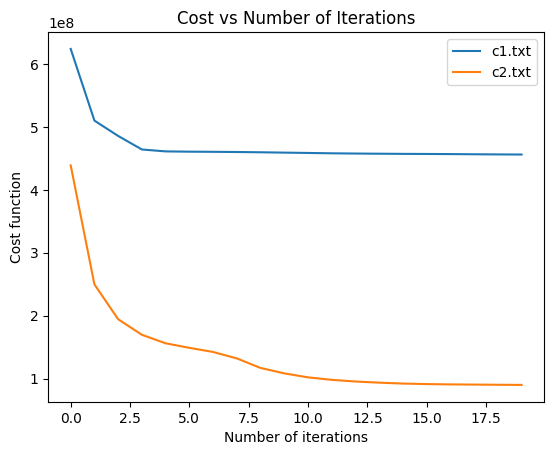

In [17]:
# Plotting the cost vs iterations for each of the centroids

import matplotlib.pyplot as plt

centroidSet1Cost = kMeansClustering(20,centroidSet1)
centroidSet2Cost = kMeansClustering(20,centroidSet2)

xAxis = [ i for i in range(20)]

plt.plot(xAxis,centroidSet1Cost,label='c1.txt')
plt.plot(xAxis,centroidSet2Cost,label='c2.txt')
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Cost vs Number of Iterations')
plt.legend()
plt.show()

In [18]:
# Percentage change in each cost
print(f'Percentage change in cost = {(centroidSet1Cost[0] - centroidSet1Cost[9])/centroidSet1Cost[0]*100} % for c1.txt')
print(f'Percentage change in cost = {(centroidSet2Cost[0] - centroidSet2Cost[9])/centroidSet2Cost[0]*100} % for c2.txt')

Percentage change in cost = 26.39886329204258 % for c1.txt
Percentage change in cost = 75.25973243724754 % for c2.txt
